In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
import datetime
from scipy.stats import linregress

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
coordinates = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=10) # Change size to 1500 after testing
lngs = np.random.uniform(lng_range[0], lng_range[1], size=10) # Change size to 1500 after testing
coordinates = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for coord in coordinates:
    city = citipy.nearest_city(coord[0], coord[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

10

In [3]:
# Request weather data (temperature, humidity, cloudiness, windspeed) from OpenWeather

successful_cities = []
lat = []
lng = []
temp = []
humidity = []
cloudiness = []
windspeed = []
country = []
date = []

print("-----------------------------------")
print("Retrieving Data – Please be patient")
print("-----------------------------------")

for city in cities:
    
    # Avoid exceeding 60 calls per minute from API request
    time.sleep(1)
    
    # Request data from API
    city_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial"
    response = requests.get(city_url).json()
    
    try:
        lat.append(response["coord"]["lat"])
        lng.append(response["coord"]["lon"])
        temp.append(response["main"]["temp_max"])
        humidity.append(response["main"]["humidity"])
        cloudiness.append(response["clouds"]["all"])
        windspeed.append(response["wind"]["speed"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        successful_cities.append(city)
        print(f"Found data for city #{len(successful_cities)}: {city}")
        
    except:
        print(f"City '{city}' not found. Proceeding to next city.")
        pass
    
print("-------------------------------------------")
print(f"Successfully retrieved data for {len(successful_cities)} cities.")
print("-------------------------------------------")

-----------------------------------
Retrieving Data – Please be patient
-----------------------------------
Found data for city #1: napier
Found data for city #2: rio grande
Found data for city #3: nikolskoye
Found data for city #4: khatanga
Found data for city #5: newberg
Found data for city #6: san patricio
Found data for city #7: albany
Found data for city #8: ushuaia
Found data for city #9: vanavara
Found data for city #10: gumdag
-------------------------------------------
Successfully retrieved data for 10 cities.
-------------------------------------------


In [4]:
# Create a dataframe
weather_df = pd.DataFrame({
    "City":successful_cities,
    "Latitude":lat,
    "Longitude":lng,
    "Max Temperature (°F)":temp,
    "Humidity (%)":humidity,
    "Cloudiness (%)":cloudiness,
    "Wind Speed (mph)":windspeed,
    "Country Code":country,
    "Date & Time":date
})

# Extract average timestamp & store for later
mean_date = weather_df["Date & Time"].mean()
retrieval_date = datetime.datetime.fromtimestamp(mean_date).date()

# Export data into a csv
weather_df.to_csv(output_data_file,index = False)


weather_df.head()

,City,Latitude,Longitude,Max Temperature (°F),Humidity (%),Cloudiness (%),Wind Speed (mph),Country Code,Date & Time
0,napier,-39.4833,176.9167,66.99,64,100,3.00,NZ,1612815084
1,rio grande,-32.0350,-52.0986,75.20,73,40,11.50,BR,1612814916
2,nikolskoye,59.7035,30.7861,5.00,84,0,3.27,RU,1612815086
3,khatanga,71.9667,102.5000,-19.21,82,0,14.05,RU,1612815087
4,newberg,45.3001,-122.9732,46.00,65,75,3.44,US,1612815014


## Scatterplots

This scatterplot shows the relationship between Temperature and Latitude of each city.

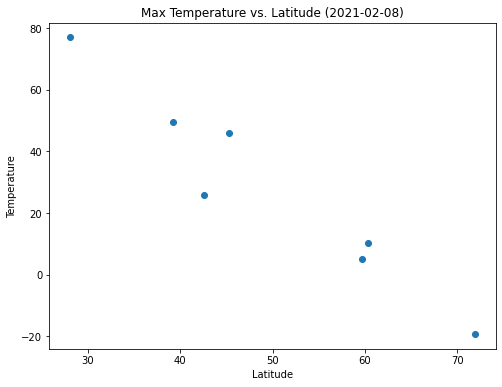

In [50]:
x_values = north_df["Latitude"]
y_values = north_df["Max Temperature (°F)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Max Temperature vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Temperature")

plt.savefig("output_data/Temperature_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Humidity and Latitude of each city.

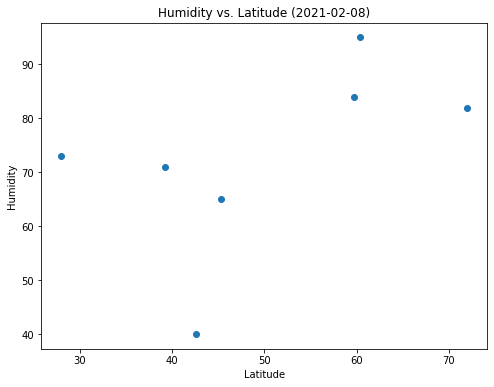

In [51]:
x_values = north_df["Latitude"]
y_values = north_df["Humidity (%)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Humidity vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Humidity")

plt.savefig("output_data/Humidity_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Cloudiness and Latitude of each city.

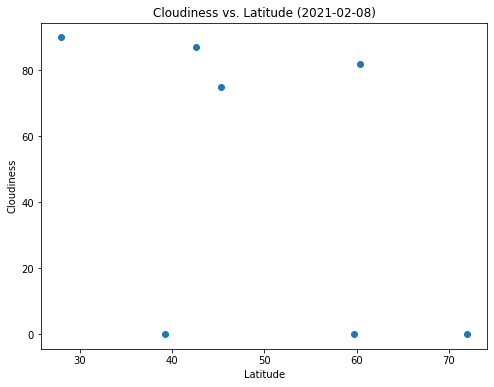

In [52]:
x_values = north_df["Latitude"]
y_values = north_df["Cloudiness (%)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Cloudiness vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")

plt.savefig("output_data/Cloudiness_vs_Latitude.png")
plt.show()

This scatterplot shows the relationship between Wind Speed and Latitude of each city.

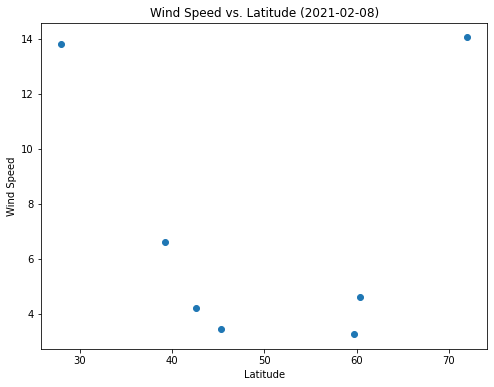

In [53]:
x_values = north_df["Latitude"]
y_values = north_df["Wind Speed (mph)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Wind Speed vs. Latitude ({retrieval_date})')
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")

plt.savefig("output_data/Wind_Speed_vs_Latitude.png")
plt.show()

## Linear Regression

To analyze each relationship using linear regression, we will separate the data by hemisphere (since we are exploring whether distance away from the equator, where latitude is zero, is correlated with the weather data).

In [54]:
# Create a DataFrame for each hemisphere

north_df = weather_df.loc[weather_df["Latitude"]>0]

south_df = weather_df.loc[weather_df["Latitude"]<0]

#### Northern Hemisphere: Temperature vs. Latitude

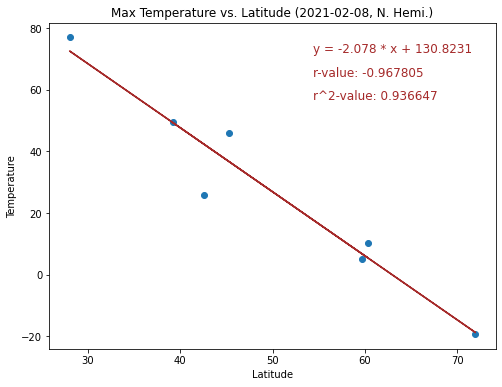

In [86]:
x_values = north_df["Latitude"]
y_values = north_df["Max Temperature (°F)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Max Temperature vs. Latitude ({retrieval_date}, N. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel("Temperature")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="brown")

x = max(x_values)-.4*(max(x_values)-min(x_values))
y_range = (max(y_values)- min(y_values))
                      
plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="brown",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="brown",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_North.png")
plt.show()

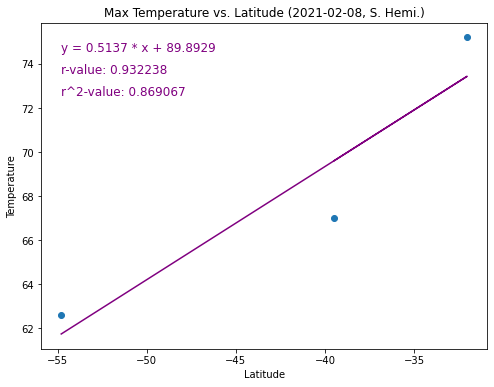

In [87]:
x_values = south_df["Latitude"]
y_values = south_df["Max Temperature (°F)"]

plt.figure(figsize=(8,6))
plt.scatter(x_values, y_values)
plt.title(f'Max Temperature vs. Latitude ({retrieval_date}, S. Hemi.)')
plt.xlabel("Latitude")
plt.ylabel("Temperature")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = slope * x_values + intercept
plt.plot(x_values, regress_values,color="purple")

x = min(x_values)
y_range = (max(y_values)- min(y_values))

plt.text(x,max(y_values)-y_range*.05,f"y = {round(slope,4)} * x + {round(intercept,4)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.13,f"r-value: {round(rvalue,6)}",c="purple",size=12)
plt.text(x,max(y_values)-y_range*.21,f"r^2-value: {round(rvalue**2,6)}",c="purple",size=12)

plt.savefig("output_data/Temperature_vs_Latitude_North.png")
plt.show()

In [ ]:
# Analysis here after testing